In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
!unzip -q "/content/drive/MyDrive/Garbage_Classification/garbage_dataset.zip" -d /content/
data_dir = "/content/garbage_dataset"

replace /content/garbage_dataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/__MACOSX/garbage_dataset/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/garbage_dataset/test/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/__MACOSX/garbage_dataset/test/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/garbage_dataset/train/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [63]:
train_dir = data_dir + "/train"
test_dir = data_dir + "/test"
val_dir = data_dir + "/validation"

In [64]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [65]:
train_gen = ImageDataGenerator(rescale=1/255,
                               rotation_range = 30,
                               width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               horizontal_flip = True,
                               vertical_flip = False,
                               fill_mode = 'reflect')

test_gen = ImageDataGenerator(rescale=1/255)

val_gen = ImageDataGenerator(rescale=1/255)

In [66]:
train_data = train_gen.flow_from_directory(directory=train_dir,
                                           target_size=(224,224),
                                           batch_size=32,
                                           class_mode='binary')

test_data = test_gen.flow_from_directory(directory=test_dir,
                                        target_size=(224,224),
                                        batch_size=32,
                                        class_mode='binary',
                                        shuffle=False)

val_data = val_gen.flow_from_directory(directory=val_dir,
                                        target_size=(224,224),
                                        batch_size=32,
                                        class_mode='binary',
                                        shuffle=False)

Found 1672 images belonging to 5 classes.
Found 357 images belonging to 5 classes.
Found 361 images belonging to 5 classes.


In [67]:
from keras.callbacks import EarlyStopping

In [68]:
base_model = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(224,224,3), weights='imagenet')
base_model.trainable = False

In [69]:
from keras.layers import GlobalAveragePooling2D

In [70]:
model = Sequential()

model.add(base_model)
model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))


In [71]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [72]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [73]:
early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
    restore_best_weights=True,
    min_delta=0.001,
)

model.fit(train_data, validation_data=val_data, epochs=30, callbacks=[early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 38s 560ms/step - accuracy: 0.4466 - loss: 1.3914 - val_accuracy: 0.7562 - val_loss: 0.7663
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 438ms/step - accuracy: 0.7493 - loss: 0.6548 - val_accuracy: 0.7535 - val_loss: 0.7001
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 429ms/step - accuracy: 0.7620 - loss: 0.5670 - val_accuracy: 0.7618 - val_loss: 0.7200
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 440ms/step - accuracy: 0.8212 - loss: 0.4751 - val_accuracy: 0.7895 - val_loss: 0.6650
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 22s 410ms/step - accuracy: 0.8257 - loss: 0.4370 - val_accuracy: 0.7645 - val_loss: 0.7139
Epoch 6/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 431ms/step - accuracy: 0.8497 - loss: 0.3754 - val_accuracy: 0.7922 - val_loss: 0.7231
Epoch 7/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 439ms/step - accuracy: 0.8636 - loss: 0.3833 - val_accuracy: 0.7895 - val_loss: 0.6894


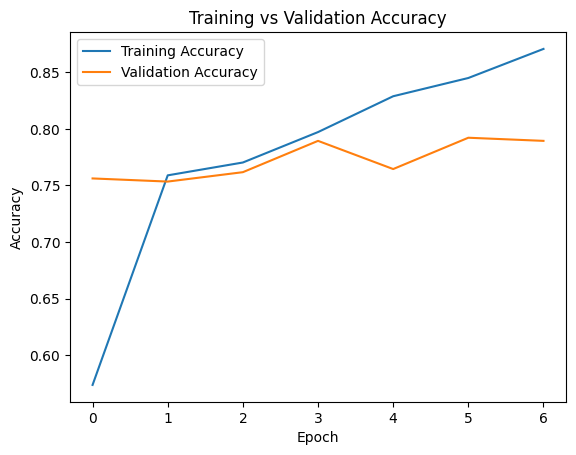

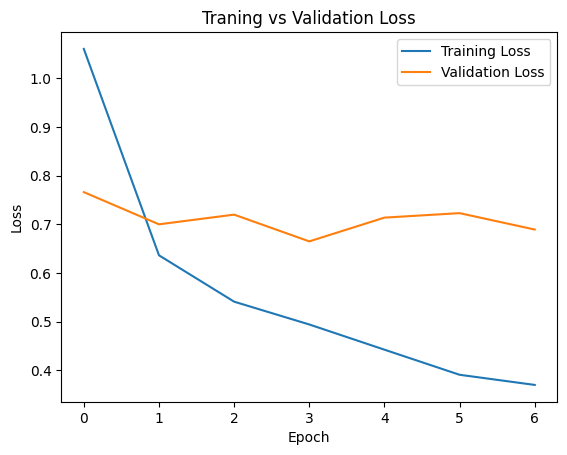

In [74]:
import matplotlib.pyplot as plt

plt.plot(model.history.history['accuracy'], label='Training Accuracy')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

plt.plot(model.history.history['loss'], label='Training Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Traning vs Validation Loss')
plt.show()

In [75]:
model.evaluate(test_data)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step - accuracy: 0.8956 - loss: 0.3407


[0.3711042106151581, 0.8963585495948792]

              precision    recall  f1-score   support

   cardboard     0.9016    0.9167    0.9091        60
       glass     0.8333    0.7333    0.7801        75
       metal     0.8382    0.9344    0.8837        61
       paper     0.9091    0.8989    0.9040        89
     plastic     0.8243    0.8472    0.8356        72

    accuracy                         0.8627       357
   macro avg     0.8613    0.8661    0.8625       357
weighted avg     0.8627    0.8627    0.8616       357



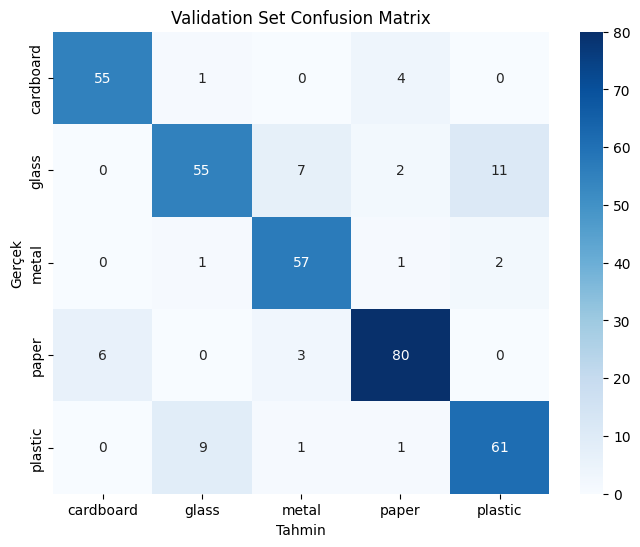

In [76]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Sınıf isimlerini güvenli şekilde al
labels = list(val_data.class_indices.keys())

# Classification Report
print(classification_report(y_true, y_pred, target_names=labels, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("Validation Set Confusion Matrix")
plt.show()


In [78]:
model.save("/content/drive/MyDrive/Garbage_Classification/model.h5")